## 🔧 Cell 1: Extract subject-comp pairs and labels

In [55]:
import numpy as np

# Step 1: Flatten subject-comp pairs with labels
records = []

for _, row in df.iterrows():
    subject = row['subject']
    comps = row['comps']
    properties = row['properties']

    for comp in comps:
        records.append({**subject, **comp, 'is_comp': 1})

    for prop in properties:
        records.append({**subject, **prop, 'is_comp': 0})

# for _, row in df.iterrows():
#     subject = row['subject']
#     comp_ids = {comp['id'] for comp in row['comps'] if isinstance(comp, dict) and 'id' in comp}
#     for prop in row['properties']:
#         if isinstance(prop, dict) and 'id' in prop:
#             record = {'is_comp': int(prop['id'] in comp_ids)}
#             for k, v in subject.items():
#                 record[f"subject_{k}"] = v
#             for k, v in prop.items():
#                 record[f"prop_{k}"] = v
#             records.append(record)

flat_df = pd.DataFrame(records)
print("Shape:", flat_df.shape)
print(flat_df['is_comp'].value_counts(normalize=True))
flat_df.head()


Shape: (9703, 63)
is_comp
0    0.972792
1    0.027208
Name: proportion, dtype: float64


,address,subject_city_province_zip,municipality_district,site_dimensions,lot_size_sf,units_sq_ft,year_built,structure_type,roofing,effective_age,...,full_baths,half_baths,main_level_finished_area,upper_lvl_fin_area,bg_fin_area,roof,close_price,public_remarks,latitude,longitude
0,930 Amberdale Cres Kingston ON K7M 6V1,"""Twin Oak Meadows""",Kingston,Condo Common Property,n/a,SqFt,1976,Townhouse,Asphalt Shingle,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,771 Ashwood Dr Kingston ON K7M 6X7,"""Twin Oak Meadows""",Kingston,Condo Common Property,n/a,SqFt,1976,Townhouse,Asphalt Shingle,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,995 Amberdale Cres Kingston ON K7M 6X6,"""Twin Oak Meadows""",Kingston,Condo Common Property,n/a,SqFt,1976,Townhouse,Asphalt Shingle,25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,463 Conservatory Dr Kingston ON K7M 9C8,"""Twin Oak Meadows""",Kingston,Condo Common Property,3555.5,SqFt,None,Detached,Asphalt Shingle,25,...,3.0,NaN,NaN,NaN,NaN,None,674000.0,Welcome to this beautifully maintained and spa...,44.2325,-76.5901
4,311 Janette St Kingston ON K7P 0K8,"""Twin Oak Meadows""",Kingston,Condo Common Property,2622.0,SqFt,None,Freehold Townhouse,Asphalt Shingle,25,...,4.0,NaN,NaN,NaN,NaN,None,585000.0,"Come and see what this fully finished, Barr co...",44.2622,-76.5904


## 📊 Cell 2: Preprocess & encode features

In [69]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Separate features and target
X = flat_df.drop(columns=["is_comp"])
y = flat_df["is_comp"]

# Remove identifier fields before training:
leaky_cols = [col for col in X.columns if 'id' in col or 'url' in col or 'photo' in col or 'address' in col]
# leaky_cols = [col for col in X.columns if 'url' in col or 'photo' in col]
print("Dropping leaky columns:", leaky_cols)
X = X.drop(columns=leaky_cols)

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

# Replace None/NaN with a placeholder
X[categorical_cols] = X[categorical_cols].fillna("missing")

# Ensure all categorical columns are strings
X[categorical_cols] = X[categorical_cols].astype(str)

# Optional: fill numeric NaNs with median
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Define transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# Fit-transform
X_processed = preprocessor.fit_transform(X)
X_processed.shape


Dropping leaky columns: ['address', 'id']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


(9703, 12757)

## 📈 Cell 3: Train XGBoost classifier

In [70]:
from xgboost import XGBClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train XGBoost
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

# Accuracy
print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:58:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 1.0
Test Accuracy: 1.0


## 🔁 Cell 4: Cross-validation

In [71]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_processed, y, cv=5, scoring="accuracy")
print("Cross-Validation Accuracy:", np.mean(scores))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:58:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:58:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:58:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:58:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation Accuracy: 1.0


## 🧠 Cell 5: SHAP explainability

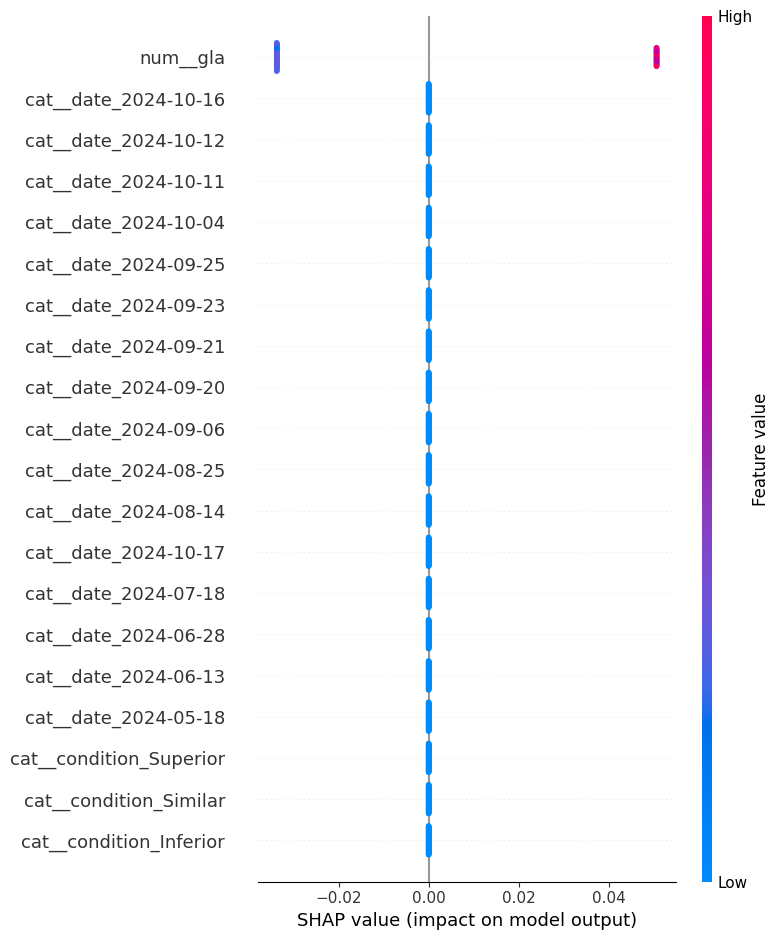

In [72]:
import shap

# SHAP can’t interpret sparse matrices directly (which OneHotEncoder returns by default).
# 👉 Fix: Convert sparse matrix to dense before passing to SHAP:
X_sample = X_processed[:100].toarray() if hasattr(X_processed, "toarray") else X_processed[:100]
# Use TreeExplainer
explainer = shap.Explainer(model, X_sample, feature_names=preprocessor.get_feature_names_out())
shap_values = explainer(X_sample)
# Summary plot (first 100 samples)
shap.summary_plot(shap_values, features=X_sample, feature_names=preprocessor.get_feature_names_out())



In [61]:
print(flat_df['is_comp'].value_counts(normalize=True))

is_comp
0    0.972792
1    0.027208
Name: proportion, dtype: float64


## Trial 5: Gradio

## ⚙️ Step 1: Install Required Packages
First, install openai to interact with Groq's LLM (since Groq supports the OpenAI client).

In [1]:
!pip install openai -q

## 🔑 Step 2: Set Groq API Key
You'll need your Groq API key (from console.groq.com).

In [2]:
import os

# Replace with your Groq API Key
# os.environ["OPENAI_API_KEY"] = "your-groq-api-key"
from google.colab import userdata
# userdata.get('secretName')


## 🌐 Step 3: Setup OpenAI Client to Use Groq

In [3]:
import openai

# Point OpenAI client to Groq's endpoint
openai.api_base = "https://api.groq.com/openai/v1"
openai.api_key = userdata.get("OPENAI_API_KEY")


## 🧠 Step 4: Build the Prompt for the LLM
Define a function that formats the subject and properties, sends them to Groq's LLM, and gets back the top recommendations:

In [22]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.2 MB/s eta 0:00:00


In [44]:
import os

from groq import Groq

client = Groq(
    api_key=userdata.get("GROQ_API_KEY"),
)

# chat_completion = client.chat.completions.create(
#     messages=[
#         {
#             "role": "user",
#             "content": "Explain the importance of fast language models",
#         }
#     ],
#     model="llama-3.3-70b-versatile",
# )

# print(chat_completion.choices[0].message.content)

In [45]:
def recommend_with_groq(subject, properties, top_n=3, model="llama3-70b-8192"):
    def format_property(p):
        return f"{p.get('address', 'N/A')} | GLA: {p.get('gla', 'N/A')}, Beds: {p.get('bedrooms', 'N/A')}, Rooms: {p.get('room_count', 'N/A')}, Style: {p.get('style', 'N/A')}, Remarks: {p.get('public_remarks', '')[:100]}"

    subject_desc = f"{subject.get('gla')} GLA, {subject.get('bedrooms')} beds, {subject.get('room_count')} rooms, {subject.get('style')} style"

    prompt = f"""You are a real estate appraisal assistant.

The subject property has the following characteristics:
{subject_desc}

Here is a list of candidate comparable properties:
"""

    for i, prop in enumerate(properties):
        prompt += f"{i+1}. {format_property(prop)}\n"

    prompt += f"""

Based on the data, recommend the top {top_n} most comparable properties. Respond with:
- A numbered list of selected properties (e.g., 1. Address)
- A short explanation of why each was selected (e.g., similar size, beds, location, etc.)

Start the answer with:
"Based on the provided data, the top {top_n} most comparable properties to the subject property ({subject_desc}) are:"
"""

    # Send to Groq
    chat_completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an expert real estate appraisal assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )

    return chat_completion.choices[0].message.content


## 🧪 Step 5: Try It on a Sample Appraisal

In [31]:
# Sample appraisal
sample = df.iloc[0]
subject = preprocess_subject(sample['subject'])
properties = [preprocess_property(p) for p in sample['properties']]

# Get LLM recommendations
response_text = recommend_with_groq(subject, properties, top_n=3)
print(response_text)


Based on the provided data, the top 3 most comparable properties to the subject property (1044 GLA, 3 beds, 6 rooms, 2-storey) are:

1. 692 Truedell Rd Kingston ON K7M 6T2
2. 786 is not available, however 728 Sussex Blvd Kingston ON K7M 5B1 
3. 1038 Springfield Drive is not available, however 912 OAKVIEW St Kingston ON K7M 6V6 

These properties are similar because they have similar characteristics, such as:
- 2-storey style
- 3 bedrooms
- Approximately 1000-1400 square feet of living space
- Similar number of rooms (6-8)
- Located in the same general area (Kingston, ON)

Please note that the exact matches are limited due to the availability of data and the specific characteristics of the subject property. These recommendations are based on the closest matches found in the provided data.


In [28]:
!pip install gradio -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00


In [46]:
def preprocess_subject_detailed(subject):
    def safe_str(val):
        return (val or '').strip()

    def safe_int(val):
        if isinstance(val, int):
            return val
        if isinstance(val, str):
            nums = re.findall(r'\d+', val)
            return int(nums[0]) if nums else 0
        return 0

    def safe_float(val):
        try:
            return float(val)
        except:
            return 0.0

    return {
        'address': safe_str(subject.get('address')),
        'city_province_zip': safe_str(subject.get('subject_city_province_zip')),
        'municipality': safe_str(subject.get('municipality_district')),
        'style': safe_str(subject.get('style')),
        'structure_type': safe_str(subject.get('structure_type')),
        'gla': safe_float(subject.get('gla')),
        'bedrooms': safe_int(subject.get('num_beds')),
        'room_count': safe_int(subject.get('room_count') or subject.get('room_total')),
        'year_built': safe_int(subject.get('year_built')),
        'condition': safe_str(subject.get('condition')),
        'age': safe_str(subject.get('subject_age')),
        'basement_area': safe_float(subject.get('basement_area')),
        'main_lvl_area': safe_float(subject.get('main_lvl_area')),
        'second_lvl_area': safe_float(subject.get('second_lvl_area')),
        'bathrooms': safe_str(subject.get('num_baths')),
    }

def preprocess_property_detailed(p):
    def safe_str(val):
        return (val or '').strip()

    def safe_int(val):
        if isinstance(val, int):
            return val
        if isinstance(val, str):
            nums = re.findall(r'\d+', val)
            return int(nums[0]) if nums else 0
        return 0

    def safe_float(val):
        try:
            return float(val)
        except:
            return 0.0

    return {
        'address': safe_str(p.get('address')),
        'gla': safe_float(p.get('gla')),
        'bedrooms': safe_int(p.get('num_beds') or p.get('bedrooms')),
        'room_count': safe_int(p.get('room_count') or p.get('room_total')),
        'style': safe_str(p.get('style')),
        'public_remarks': safe_str(p.get('public_remarks')),
    }


In [47]:
import gradio as gr

# Prepare list of subject options
subject_options = []
appraisal_map = {}

for i, row in df.iterrows():
    subject_raw = row['subject']
    subject = preprocess_subject_detailed(subject_raw)
    address = subject.get('address', 'Unknown')
    gla = subject.get('gla', 0)
    beds = subject.get('bedrooms', 0)
    label = f"{i}: {address} | GLA: {gla}, Beds: {beds}"

    subject_options.append(label)
    appraisal_map[label] = row


def gradio_recommend(selected_label):
    row = appraisal_map[selected_label]
    subject = preprocess_subject(row['subject'])
    properties = [preprocess_property_detailed(p) for p in row['properties']]

    try:
        response = recommend_with_groq(subject, properties, top_n=3)
        return response
    except Exception as e:
        return f"Error: {e}"

# Gradio interface
dropdown = gr.Dropdown(choices=subject_options, label="Select Subject Property")
output = gr.Textbox(label="Groq LLM Recommendation", lines=10)

demo = gr.Interface(
    fn=gradio_recommend,
    inputs=[dropdown],
    outputs=[output],
    title="Comparable Property Recommender (LLM-powered)",
    description="Select a subject property to get top 3 LLM-recommended comparable properties."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ff7e292da4af42707d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Trial 4

In [6]:
!pip install xgboost pandas scikit-learn matplotlib -q

In [9]:
import json
import pandas as pd

# Step 1: Load deduplicated dataset
with open('deduplicated_appraisals_dataset.json', 'r') as f:
    data = json.load(f)

# Step 2: Ensure data is in expected format
# If top-level is a list, wrap in a dict with 'appraisals' key for compatibility
if isinstance(data, list):
    data = {'appraisals': data}

# Step 3: Flatten appraisals into DataFrame
df = pd.DataFrame(data['appraisals'])

# Step 4: Sanity-check structure
df['subject'] = df['subject'].apply(lambda x: x if isinstance(x, dict) else {})
df['comps'] = df['comps'].apply(lambda x: x if isinstance(x, list) else [])
df['properties'] = df['properties'].apply(lambda x: x if isinstance(x, list) else [])

df.head()


,orderID,subject,comps,properties
0,4762597,{'address': '142-950 Oakview Ave Kingston ON K...,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr K..."
1,4762739,"{'address': '7180 207 HWY Halifax NS B0J2L0', ...","[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro..."
2,4763065,"{'address': '11 PAUL AVE Ayr ON N0B1E0', 'subj...","[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan..."
3,4763086,{'address': '102 Stonewalk Dr Kemptville ON K0...,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ..."
4,4763087,{'address': '407 105 Dunbrack St Halifax NS B3...,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court NS ..."


In [37]:
import re

def safe_int(value):
    if isinstance(value, int):
        return value
    if isinstance(value, str):
        numbers = re.findall(r'\d+', value)
        return sum(map(int, numbers)) if numbers else 0
    return 0

def safe_float(value):
    try:
        return float(value)
    except:
        return 0.0

def preprocess_subject(subject):
    return {
        'gla': safe_float(subject.get('gla', 0)),
        'bedrooms': safe_int(subject.get('num_beds', 0)),
        'room_count': safe_int(subject.get('room_count', 0)),
        'structure_type': (subject.get('structure_type') or '').strip().lower(),
        'style': (subject.get('style') or '').strip().lower(),
    }

def preprocess_property(p):
    return {
        'id': p['id'],
        'address': p.get('address'),
        'gla': safe_float(p.get('gla')),
        'bedrooms': safe_int(p.get('bedrooms')),
        'room_count': safe_int(p.get('room_count')),
        'structure_type': (p.get('structure_type') or '').strip().lower(),
        'style': (p.get('style') or '').strip().lower(),
        'close_price': p.get('close_price'),
        'close_date': p.get('close_date'),
        'public_remarks': (p.get('public_remarks') or ''),
        'original': p
    }


In [11]:
def get_similar_properties(subject, properties, top_n=3):
    subject_feat = preprocess_subject(subject)
    props = [preprocess_property(p) for p in properties]

    # Filter: match structure type (e.g. Townhouse → exclude Apartments)
    filtered = [p for p in props if p['structure_type'] == subject_feat['structure_type'] and abs(p['gla'] - subject_feat['gla']) < 300]

    if not filtered:
        return []

    df_props = pd.DataFrame(filtered)

    # Combine numerical features
    X = df_props[['gla', 'bedrooms', 'room_count']].copy()
    subj_vec = np.array([[subject_feat['gla'], subject_feat['bedrooms'], subject_feat['room_count']]])

    # Scale & compute cosine similarity
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # subj_scaled = scaler.transform(subj_vec)
    subj_scaled = scaler.transform(pd.DataFrame(subj_vec, columns=['gla', 'bedrooms', 'room_count']))
    sims = cosine_similarity(subj_scaled, X_scaled)[0]

    df_props['similarity'] = sims
    top_props = df_props.sort_values(by='similarity', ascending=False).head(top_n)

    # Add explanation
    explanations = []
    for _, row in top_props.iterrows():
        expl = []
        if abs(row['gla'] - subject_feat['gla']) <= 50: expl.append('Similar GLA')
        if row['bedrooms'] == subject_feat['bedrooms']: expl.append('Same bedrooms')
        if row['structure_type'] == subject_feat['structure_type']: expl.append('Same structure type')
        explanations.append({
            **row['original'],
            'similarity_score': round(row['similarity'], 2),
            'explanation': ', '.join(expl)
        })

    return explanations


In [12]:
from difflib import SequenceMatcher

def fuzzy_match(a, b):
    return SequenceMatcher(None, a.lower().strip(), b.lower().strip()).ratio() > 0.85

def evaluate_recommendations(appraisals, top_n=3):
    correct = total = 0
    examples = []

    for appraisal in appraisals:
        subject = appraisal.get('subject')
        properties = appraisal.get('properties', [])
        true_comps = appraisal.get('comps', [])
        true_addresses = [c.get('address', '').lower().strip() for c in true_comps]

        if not subject or not properties or not true_comps:
            continue

        recs = get_similar_properties(subject, properties, top_n=top_n)
        rec_addresses = [r['address'].lower().strip() for r in recs]

        # Check if any recommended address matches ground truth
        match_count = sum(any(fuzzy_match(rec, truth) for truth in true_addresses) for rec in rec_addresses)

        correct += match_count
        total += top_n

        examples.append({
            'orderID': appraisal.get('orderID'),
            'true_comps': true_addresses,
            'recommended_comps': rec_addresses,
            'matches_found': match_count
        })

    precision = correct / total if total > 0 else 0
    print(f"Top-{top_n} Recommendation Precision: {precision:.2f}")
    return examples


In [18]:
# Load necessary packages
import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re

results = evaluate_recommendations(df.to_dict(orient='records'), top_n=3)

# Display sample evaluation results
import random
for sample in random.sample(results, 3):
    print(json.dumps(sample, indent=2))


Top-3 Recommendation Precision: 0.03
{
  "orderID": "4758025",
  "true_comps": [
    "4 rockcliff pt nw calgary ab t3g 5z4",
    "61 rockford rd nw calgary ab t3g 0e1",
    "1 rock lake pt nw calgary ab t3g 0e9"
  ],
  "recommended_comps": [],
  "matches_found": 0
}
{
  "orderID": "4762154",
  "true_comps": [
    "306-79 bedros lane halifax ns b3m 4x5",
    "401-11 springvale ave halifax ns b3n 0a3",
    "111-11 springvale ave halifax ns b3n 0a3"
  ],
  "recommended_comps": [
    "unit 514 202 walter havill drive ns b3n 3m4",
    "92 forestside crescent ns b3m 1m4",
    "unit 1306 3471 dutch village road ns b3n 0c7"
  ],
  "matches_found": 0
}
{
  "orderID": "4778794",
  "true_comps": [
    "701-121 queen st kingston on k7k 0g6",
    "920-652 princess st kingston on k7l 1e5",
    "403-501 frontenac st kingston on k7k 4l9"
  ],
  "recommended_comps": [],
  "matches_found": 0
}


## Trial 3

## 📦 1. Setup and Load Dataset

In [ ]:
# Clone repo & change directory
!git clone https://github.com/H4mzaCode/CompRecommendation.git
%cd CompRecommendation

# Load necessary packages
import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re


Cloning into 'CompRecommendation'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 4.67 MiB | 5.96 MiB/s, done.
/content/CompRecommendation/CompRecommendation/CompRecommendation


## 📂 2. Load and Flatten JSON

In [ ]:
# Load the dataset
with open('appraisals_dataset.json', 'r') as f:
    data = json.load(f)

# Flatten appraisals
df = pd.DataFrame(data['appraisals'])
df['subject'] = df['subject'].apply(lambda x: x if isinstance(x, dict) else {})
df['comps'] = df['comps'].apply(lambda x: x if isinstance(x, list) else [])
df['properties'] = df['properties'].apply(lambda x: x if isinstance(x, list) else [])
df.head()


,orderID,subject,comps,properties
0,4762597,{'address': '142-950 Oakview Ave Kingston ON K...,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',..."
1,4762739,"{'address': '7180 207 HWY Halifax NS B0J2L0', ...","[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro..."
2,4763065,"{'address': '11 PAUL AVE Ayr ON N0B1E0', 'subj...","[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan..."
3,4763086,{'address': '102 Stonewalk Dr Kemptville ON K0...,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ..."
4,4763087,{'address': '407 105 Dunbrack St Halifax NS B3...,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '..."


## 🧹 3. Clean and Preprocess Helper Functions

In [ ]:
import re

def safe_int(value):
    if isinstance(value, int):
        return value
    if isinstance(value, str):
        numbers = re.findall(r'\d+', value)
        return sum(map(int, numbers)) if numbers else 0
    return 0

def safe_float(value):
    try:
        return float(value)
    except:
        return 0.0

def preprocess_subject(subject):
    return {
        'gla': safe_float(subject.get('gla', 0)),
        'bedrooms': safe_int(subject.get('num_beds', 0)),
        'room_count': safe_int(subject.get('room_count', 0)),
        'structure_type': (subject.get('structure_type') or '').strip().lower(),
        'style': (subject.get('style') or '').strip().lower(),
    }

def preprocess_property(p):
    return {
        'id': p['id'],
        'address': p.get('address'),
        'gla': safe_float(p.get('gla')),
        'bedrooms': safe_int(p.get('bedrooms')),
        'room_count': safe_int(p.get('room_count')),
        'structure_type': (p.get('structure_type') or '').strip().lower(),
        'style': (p.get('style') or '').strip().lower(),
        'close_price': p.get('close_price'),
        'close_date': p.get('close_date'),
        'public_remarks': (p.get('public_remarks') or ''),
        'original': p
    }


## 🧠 4. Matching Logic: Filter + Similarity + Explanation

In [ ]:
def get_similar_properties(subject, properties, top_n=3):
    subject_feat = preprocess_subject(subject)
    props = [preprocess_property(p) for p in properties]

    # Filter: match structure type (e.g. Townhouse → exclude Apartments)
    filtered = [p for p in props if p['structure_type'] == subject_feat['structure_type'] and abs(p['gla'] - subject_feat['gla']) < 300]

    if not filtered:
        return []

    df_props = pd.DataFrame(filtered)

    # Combine numerical features
    X = df_props[['gla', 'bedrooms', 'room_count']].copy()
    subj_vec = np.array([[subject_feat['gla'], subject_feat['bedrooms'], subject_feat['room_count']]])

    # Scale & compute cosine similarity
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # subj_scaled = scaler.transform(subj_vec)
    subj_scaled = scaler.transform(pd.DataFrame(subj_vec, columns=['gla', 'bedrooms', 'room_count']))
    sims = cosine_similarity(subj_scaled, X_scaled)[0]

    df_props['similarity'] = sims
    top_props = df_props.sort_values(by='similarity', ascending=False).head(top_n)

    # Add explanation
    explanations = []
    for _, row in top_props.iterrows():
        expl = []
        if abs(row['gla'] - subject_feat['gla']) <= 50: expl.append('Similar GLA')
        if row['bedrooms'] == subject_feat['bedrooms']: expl.append('Same bedrooms')
        if row['structure_type'] == subject_feat['structure_type']: expl.append('Same structure type')
        explanations.append({
            **row['original'],
            'similarity_score': round(row['similarity'], 2),
            'explanation': ', '.join(expl)
        })

    return explanations


## 📊 5. Evaluate Recommendations vs. Ground Truth

In [ ]:
from difflib import SequenceMatcher

def fuzzy_match(a, b):
    return SequenceMatcher(None, a.lower().strip(), b.lower().strip()).ratio() > 0.85

def evaluate_recommendations(appraisals, top_n=3):
    correct = total = 0
    examples = []

    for appraisal in appraisals:
        subject = appraisal.get('subject')
        properties = appraisal.get('properties', [])
        true_comps = appraisal.get('comps', [])
        true_addresses = [c.get('address', '').lower().strip() for c in true_comps]

        if not subject or not properties or not true_comps:
            continue

        recs = get_similar_properties(subject, properties, top_n=top_n)
        rec_addresses = [r['address'].lower().strip() for r in recs]

        # Check if any recommended address matches ground truth
        match_count = sum(any(fuzzy_match(rec, truth) for truth in true_addresses) for rec in rec_addresses)

        correct += match_count
        total += top_n

        examples.append({
            'orderID': appraisal.get('orderID'),
            'true_comps': true_addresses,
            'recommended_comps': rec_addresses,
            'matches_found': match_count
        })

    precision = correct / total if total > 0 else 0
    print(f"Top-{top_n} Recommendation Precision: {precision:.2f}")
    return examples


## 🚀 6. Run on All Appraisals and See Examples

In [ ]:
results = evaluate_recommendations(df.to_dict(orient='records'), top_n=3)

# Display sample evaluation results
import random
for sample in random.sample(results, 3):
    print(json.dumps(sample, indent=2))


Top-3 Recommendation Precision: 0.00
{
  "orderID": "4770115",
  "true_comps": [
    "189 blackhorse dr",
    "116 blackhorse dr",
    "13 tilly lane"
  ],
  "recommended_comps": [],
  "matches_found": 0
}
{
  "orderID": "4759846",
  "true_comps": [
    "36 mount pleasant ave",
    "2 lawnsdale dr",
    "40 kingston cres"
  ],
  "recommended_comps": [],
  "matches_found": 0
}
{
  "orderID": "4742669",
  "true_comps": [
    "523 35a st nw",
    "2425 3 ave nw",
    "2536 4 ave nw"
  ],
  "recommended_comps": [],
  "matches_found": 0
}


## Trial 2

In [ ]:
# Property Recommendation System - Starter Code

# Clone the repository
!git clone https://github.com/H4mzaCode/CompRecommendation.git
%cd CompRecommendation

# Install dependencies if needed
# !pip install pandas scikit-learn numpy

import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
with open('appraisals_dataset.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(data['appraisals'])
df.head()


Cloning into 'CompRecommendation'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 4.67 MiB | 3.38 MiB/s, done.
/content/CompRecommendation


,orderID,subject,comps,properties
0,4762597,{'address': '142-950 Oakview Ave Kingston ON K...,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',..."
1,4762739,"{'address': '7180 207 HWY Halifax NS B0J2L0', ...","[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro..."
2,4763065,"{'address': '11 PAUL AVE Ayr ON N0B1E0', 'subj...","[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan..."
3,4763086,{'address': '102 Stonewalk Dr Kemptville ON K0...,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ..."
4,4763087,{'address': '407 105 Dunbrack St Halifax NS B3...,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '..."


In [ ]:
# Extract nested columns
df['subject'] = df['subject']
df['comps'] = df['comps']
df['properties'] = df['properties']

# Feature extraction function
def extract_features(prop):
    def safe_float(val):
        try:
            return float(str(val).replace(",", "").replace("SqFt", "").strip())
        except:
            return 0.0

    return [
        safe_float(prop.get('gla', 0)),
        safe_float(prop.get('lot_size_sf', 0)),
        int(prop.get('bedrooms', 0) or 0),
        int(prop.get('room_count', 0) or 0),
        safe_float(prop.get('close_price', 0))
    ]

# Build feature matrix and similarity logic
recommendations = []
for i, row in df.iterrows():
    subject_vec = extract_features(row['subject'])
    candidate_vecs = [extract_features(p) for p in row['properties']]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform([subject_vec] + candidate_vecs)
    subj_scaled = X_scaled[0]
    candidates_scaled = X_scaled[1:]

    sims = cosine_similarity([subj_scaled], candidates_scaled)[0]
    top3_idx = np.argsort(sims)[-3:][::-1]
    top3_props = [row['properties'][idx] for idx in top3_idx]

    recommendations.append({
        'orderID': row['orderID'],
        'recommended_comps': top3_props
    })

# Example output
import pprint
pprint.pprint(recommendations[0])


{'orderID': '4762597',
 'recommended_comps': [{'address': 'Unit 402 - 649 DAVIS Dr',
                        'basement': None,
                        'bedrooms': 2,
                        'bg_fin_area': None,
                        'city': 'Kingston',
                        'close_date': '2025-01-24',
                        'close_price': 330000.0,
                        'cooling': 'Window Unit',
                        'full_baths': 1,
                        'gla': 1100,
                        'half_baths': 0,
                        'heating': 'Baseboard',
                        'id': 2682,
                        'latitude': 44.254,
                        'levels': None,
                        'longitude': -76.5675,
                        'lot_size_sf': None,
                        'main_level_finished_area': None,
                        'postal_code': 'L9P 1R2',
                        'property_sub_type': 'Condo Apt',
                        'province': 'Ontario',
  

## Trial 1

In [ ]:
# Clone the repository
!git clone https://github.com/H4mzaCode/CompRecommendation.git
%cd CompRecommendation

# Import necessary libraries
import json
import pandas as pd

# Load the dataset
with open('appraisals_dataset.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)
df.head()


Cloning into 'CompRecommendation'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 4.67 MiB | 8.49 MiB/s, done.
/content/CompRecommendation/CompRecommendation


,appraisals
0,"{'orderID': '4762597', 'subject': {'address': ..."
1,"{'orderID': '4762739', 'subject': {'address': ..."
2,"{'orderID': '4763065', 'subject': {'address': ..."
3,"{'orderID': '4763086', 'subject': {'address': ..."
4,"{'orderID': '4763087', 'subject': {'address': ..."


In [ ]:
df.head()

,appraisals
0,"{'orderID': '4762597', 'subject': {'address': ..."
1,"{'orderID': '4762739', 'subject': {'address': ..."
2,"{'orderID': '4763065', 'subject': {'address': ..."
3,"{'orderID': '4763086', 'subject': {'address': ..."
4,"{'orderID': '4763087', 'subject': {'address': ..."


In [ ]:
# Extract nested columns from the 'appraisals' column
df['subject'] = df['appraisals'].apply(lambda x: x.get('subject'))
df['comps'] = df['appraisals'].apply(lambda x: x.get('comps'))
df['properties'] = df['appraisals'].apply(lambda x: x.get('properties'))

# Drop the original 'appraisals' column
df.drop(columns=['appraisals'], inplace=True)

# Display the first few rows to verify the structure
df.head()


,subject,comps,properties
0,{'address': '142-950 Oakview Ave Kingston ON K...,"[{'distance_to_subject': '0.15 KM', 'prop_type...","[{'id': 367, 'address': '463 Conservatory Dr',..."
1,"{'address': '7180 207 HWY Halifax NS B0J2L0', ...","[{'distance_to_subject': '3.73 KM', 'prop_type...","[{'id': 297301, 'address': '638 Myers Point Ro..."
2,"{'address': '11 PAUL AVE Ayr ON N0B1E0', 'subj...","[{'distance_to_subject': '0.31 KM', 'prop_type...","[{'id': 116134, 'address': '246 Waterbrook Lan..."
3,{'address': '102 Stonewalk Dr Kemptville ON K0...,"[{'distance_to_subject': '0.78 KM', 'prop_type...","[{'id': 1849, 'address': '501 CLOTHIER Street ..."
4,{'address': '407 105 Dunbrack St Halifax NS B3...,"[{'distance_to_subject': '0.00 KM', 'prop_type...","[{'id': 293769, 'address': '3 Apollo Court', '..."


In [ ]:
# Function to clean and convert numeric values
def clean_numeric(value):
    if pd.isna(value):
        return None
    value = str(value).replace(",", "").replace(" SqFt", "").replace(" KM", "").replace("$", "").strip()
    return pd.to_numeric(value, errors='coerce')

# Clean and convert relevant columns in the 'subject' property
df['subject_gla'] = df['subject'].apply(lambda x: clean_numeric(x.get('gla')))
df['subject_lot_size_sf'] = df['subject'].apply(lambda x: clean_numeric(x.get('lot_size_sf')))
df['subject_year_built'] = df['subject'].apply(lambda x: pd.to_numeric(x.get('year_built'), errors='coerce'))

# Display cleaned subject data
df[['subject_gla', 'subject_lot_size_sf', 'subject_year_built']].head()


,subject_gla,subject_lot_size_sf,subject_year_built
0,1044.0,NaN,1976.0
1,1500.0,NaN,2011.0
2,3000.0,20174.0,1983.0
3,1283.0,NaN,NaN
4,1530.0,NaN,1978.0


In [ ]:
# Remove duplicate comparable properties within each row (by address)
def remove_duplicate_comps(comps):
    unique_addresses = set()
    cleaned_comps = []
    for comp in comps:
        if comp['address'] not in unique_addresses:
            cleaned_comps.append(comp)
            unique_addresses.add(comp['address'])
    return cleaned_comps

df['comps'] = df['comps'].apply(remove_duplicate_comps)


In [ ]:
import re

# Enhanced clean_numeric function to handle complex age strings
def clean_numeric(value):
    if pd.isna(value):
        return None
    if isinstance(value, str):
        # Remove any non-numeric characters (except dot for decimals)
        value = re.sub(r'[^\d.-]', '', value).strip()
    try:
        return float(value)
    except ValueError:
        return None

# Apply the cleaning function to the subject property
df['subject_gla'] = df['subject'].apply(lambda x: clean_numeric(x.get('gla')))
df['subject_lot_size_sf'] = df['subject'].apply(lambda x: clean_numeric(x.get('lot_size_sf')))
df['subject_year_built'] = df['subject'].apply(lambda x: pd.to_numeric(x.get('year_built'), errors='coerce'))

# Function to extract and calculate features for each comparable property
def feature_engineering(subject, comp):
    subject_gla = clean_numeric(subject.get('gla'))
    subject_age = clean_numeric(subject.get('subject_age'))  # Use clean_numeric for age

    comp_gla = clean_numeric(comp.get('gla'))
    comp_age = clean_numeric(comp.get('age'))

    features = {
        'distance': clean_numeric(comp.get('distance_to_subject')),
        'gla_diff': abs(comp_gla - subject_gla) if comp_gla and subject_gla else None,
        'age_diff': abs(comp_age - subject_age) if comp_age and subject_age else None,
        'condition_sim': 1 if comp.get('condition') == subject.get('condition') else 0,
        'style_sim': 1 if comp.get('stories') == subject.get('style') else 0
    }
    return features

# Apply feature engineering to all comps
df['comp_features'] = df.apply(
    lambda row: [feature_engineering(row['subject'], comp) for comp in row['comps']], axis=1
)

# Display the first few rows with extracted features
df[['comp_features']].head()


,comp_features
0,"[{'distance': 0.15, 'gla_diff': 0.0, 'age_diff..."
1,"[{'distance': 3.73, 'gla_diff': None, 'age_dif..."
2,"[{'distance': 0.31, 'gla_diff': 997.0, 'age_di..."
3,"[{'distance': 0.78, 'gla_diff': 288.0, 'age_di..."
4,"[{'distance': 0.0, 'gla_diff': 482.0, 'age_dif..."


In [ ]:
import numpy as np

# Flattening the comp features for training
all_features = []
all_labels = []

for _, row in df.iterrows():
    for comp_features in row['comp_features']:
        all_features.append(list(comp_features.values()))
        all_labels.append(row['orderID'])

X = np.array(all_features)
y = np.array(all_labels)

print("Feature Shape:", X.shape)


KeyError: 'orderID'